### Imports

In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import clip as clip
import torch

In [6]:
import pandas as pd
with open('list_attr_img_full.csv') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content =[x.strip() for x in content] 

In [7]:
from tqdm import tqdm
d = []
for line in tqdm(content[2:]):
    d.append(
        {
            'image_name': line.split(';')[0],
            'Attributes' : [x for x in line.split(';')[1:] if x != '']
        }
    )

attribute_df_2 = pd.DataFrame(d)
pd.set_option('display.max_colwidth', None)

100%|██████████| 289222/289222 [00:29<00:00, 9656.94it/s] 


In [8]:
with open('list_attr_cloth (1).txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
#content = [x.strip() for x in content]

d = []
for line in content[2:]:
    #print(line.split("   "))
    d.append(
        {
            'attribute': line.split("       ")[0].strip(),
            'attribute_type' : line.split("   ")[-1].strip()
        }
    )

attribute_df_text = pd.DataFrame(d)
attribute_2_dict = {key:value for key, value in enumerate(attribute_df_text['attribute'])}

In [9]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [77]:
predictions = pd.read_csv('predictions_balanced_sample.csv')
attribute_df_2 = attribute_df_2[attribute_df_2['image_name'].isin(predictions['image_name'])]

In [11]:
attribute_df_2['attributes'] = np.nan

pd.options.mode.chained_assignment = None

for elem in attribute_df_2.index:
    index_list = list_duplicates_of(attribute_df_2['Attributes'].loc[elem], '1')
    
    attribute_list = []
    
    for index in index_list:
        attribute_list.append(attribute_2_dict[index])
    
    attribute_df_2['attributes'].loc[elem] = attribute_list

In [12]:
attribute_df_2 = attribute_df_2.drop('Attributes', axis=1)

In [13]:
attribute_df_2

,image_name,attributes
123,img/Sheer_Pleated-Front_Blouse/img_00000124.jpg,"[georgette, long sleeve, pleated, sheer, sleeve]"
1447,img/Slub_Knit_Buttoned-Back_Blouse/img_00000080.jpg,"[knit, mesh, shirt, sleeveless, slub, yoke]"
1453,img/Slub_Knit_Buttoned-Back_Blouse/img_00000086.jpg,"[linen, shirt]"
2982,img/Striped_Tribal_Print_Blouse/img_00000024.jpg,"[pocket, striped]"
3066,img/Striped_Tribal_Print_Blouse/img_00000108.jpg,"[print, tribal]"
...,...,...
286977,img/Cotton_Twill_Trench_Coat/img_00000039.jpg,"[cotton, trench, twill]"
286982,img/Cotton_Twill_Trench_Coat/img_00000044.jpg,"[cotton, trench, twill]"
286996,img/Cotton_Twill_Trench_Coat/img_00000058.jpg,"[cotton, leather, logo, trench, twill]"
287607,img/Crochet_Flounce_Romper/img_00000006.jpg,"[crochet, crochet lace, hem, lace, strap]"


# Attribute prediction different style

In [14]:
attributes = attribute_df_text.attribute.to_list()

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

text_input = clip.tokenize(attributes).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

/home/mlc/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/clip/clip.py:53: UserWarning: /home/mlc/.cache/clip/ViT-B-32.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 19.7MiB/s]


Tokens shape: torch.Size([1000, 77])
Text features shape: torch.Size([1000, 512])


In [19]:
attribute_df_2["prediction"] = np.nan
attribute_df_2["prediction"] = pd.Series([], dtype=object)
#PATH_img = "/Volumes/ToshibaLouk/DeepFashion"
attr_dict = {key: value for (key, value) in enumerate(attributes)}

for elem in attribute_df_2.index:
    path = attribute_df_2['image_name'][elem]
    img = Image.open(path)
    image_input = preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    #index = output.cpu().data.numpy().argmax()
    values_5, indices_5 = similarity[0].topk(5)
    
    prediction = indices_5.cpu().numpy()
    
    #print(prediction)
   
    attribute_df_2['prediction'].loc[elem] = prediction
    
#attribute_df_2 = attribute_df_2.replace({"prediction": a_dict})


In [21]:
for elem in attribute_df_2.index:
    attribute_df_2['prediction'].loc[elem] = [attribute_2_dict[a] for a in attribute_df_2['prediction'].loc[elem]]

In [27]:
#attribute_df_2.to_csv('simple_predictions.csv', index=False)

In [5]:
#attribute_df_2 = pd.read_csv('/Users/louk/Desktop/Master Thesis/simple_predictions.csv')

In [22]:
attribute_df_2 = attribute_df_2.rename(columns={'prediction': "top_5_attributes"})

In [24]:
torch.cuda.empty_cache()

## Top_3 Attributes

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

text_input = clip.tokenize(attributes).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([1000, 77])


RuntimeError: CUDA out of memory. Tried to allocate 152.00 MiB (GPU 0; 7.79 GiB total capacity; 1.96 GiB already allocated; 51.81 MiB free; 2.23 GiB reserved in total by PyTorch)

In [26]:
attribute_df_2["top_3_attributes"] = np.nan
attribute_df_2["top_3_attributes"] = pd.Series([], dtype=object)
PATH_img = "/Volumes/ToshibaLouk/DeepFashion"
attr_dict = {key: value for (key, value) in enumerate(attributes)}

for elem in attribute_df_2.index:
    path = PATH_img + '/' + attribute_df_2['image_name'][elem]
    img = Image.open(path)
    image_input = preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    values_3, indices_3 = similarity[0].topk(3)
    
    prediction = indices_3.numpy()
    
    #print(prediction)
   
    attribute_df_2['top_3_attributes'].loc[elem] = prediction
    
#attribute_df_2 = attribute_df_2.replace({"prediction": a_dict})


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ToshibaLouk/DeepFashion/img/Sheer_Pleated-Front_Blouse/img_00000124.jpg'

In [21]:
for elem in attribute_df_2.index:
    attribute_df_2['top_3_attributes'].loc[elem] = [attribute_2_dict[a] for a in attribute_df_2['top_3_attributes'].loc[elem]]

In [22]:
attribute_df_2

,image_name,attributes,top_5_attributes,top_3_attributes
0,img/Sheer_Pleated-Front_Blouse/img_00000124.jpg,"['georgette', 'long sleeve', 'pleated', 'sheer...","['dolman-sleeve', 'chiffon shirt', 'dolman sle...","[dolman-sleeve, chiffon shirt, dolman sleeve]"
1,img/Slub_Knit_Buttoned-Back_Blouse/img_0000008...,"['killin', 'medallion', 'sheer', 'skort', 'sli...","['chiffon shirt', 'boxy crop', 'print v-neck',...","[chiffon shirt, boxy crop, print v-neck]"
2,img/Slub_Knit_Buttoned-Back_Blouse/img_0000008...,"['leopard print', 'sheer']","['chiffon shirt', 'chiffon paneled', 'dolman-s...","[chiffon shirt, chiffon paneled, dolman-sleeve]"
3,img/Striped_Tribal_Print_Blouse/img_00000024.jpg,"['pleated woven', 'stripe']","['nautical stripe', 'breton stripe', 'low-rise...","[nautical stripe, breton stripe, low-rise skinny]"
4,img/Striped_Tribal_Print_Blouse/img_00000108.jpg,"['power', 'triangle']","['raglan sleeve', 'print v-neck', 'knit v-neck...","[raglan sleeve, print v-neck, knit v-neck]"
...,...,...,...,...
495,img/Cotton_Twill_Trench_Coat/img_00000039.jpg,"['cotton', 'trench', 'twill']","['shearling', 'faux leather-trimmed', 'hooded ...","[shearling, faux leather-trimmed, hooded utility]"
496,img/Cotton_Twill_Trench_Coat/img_00000044.jpg,"['cotton', 'trench', 'twill']","['shearling', 'zip-front', 'faux leather-trimm...","[shearling, zip-front, faux leather-trimmed]"
497,img/Cotton_Twill_Trench_Coat/img_00000058.jpg,"['cotton', 'leather', 'logo', 'trench', 'twill']","['tweed', 'bell-sleeve', 'dolman-sleeve', 'she...","[tweed, bell-sleeve, dolman-sleeve]"
498,img/Crochet_Flounce_Romper/img_00000006.jpg,"['crochet', 'crochet lace', 'hem', 'lace', 'st...","['bodycon', 'cami maxi', 'asymmetrical hem', '...","[bodycon, cami maxi, asymmetrical hem]"


## Category prediction

In [3]:
df = pd.read_csv('test_labels.csv')
total_df = pd.merge(attribute_df_2, category_df, on='image_name', how='outer')

FileNotFoundError: [Errno 2] No such file or directory: 'test_labels.csv'

In [79]:
df

,image_name,category_name
0,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000013.jpg,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000019.jpg,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000020.jpg,Blouse
...,...,...
39995,img/Paisley_Maxi_Cami_Dress/img_00000010.jpg,Dress
39996,img/Paisley_Maxi_Cami_Dress/img_00000021.jpg,Dress
39997,img/Paisley_Maxi_Cami_Dress/img_00000023.jpg,Dress
39998,img/Paisley_Print_Babydoll_Dress/img_00000044.jpg,Dress


In [80]:
category_df = df[df['image_name'].isin(attribute_df_2['image_name'].to_list())][['image_name', 'category_name']]

In [85]:
total_df = pd.merge(attribute_df_2, category_df, on='image_name', how='outer')

In [87]:
categories = total_df['category_name'].unique()
category_dict = {key: value for (key, value) in enumerate(categories)}

In [88]:
text_input = clip.tokenize(total_df['category_name'].unique()).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([39, 77])
Text features shape: torch.Size([39, 512])


### Category prediction

In [105]:
total_df["top_5_category"] = np.nan
total_df["top_5_category"] = pd.Series([], dtype=object)

for elem in total_df.index:
    path = total_df['image_name'][elem]
    img = Image.open(path)
    image_input = preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        
    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    values_5, indices_5 = similarity[0].topk(5)
    
    prediction = indices_5.cpu().numpy()
   
    total_df['top_5_category'].loc[elem] = prediction
    
#sample = sample.replace({"prediction": a_dict})


In [108]:
for elem in total_df.index:
    total_df['top_5_category'].loc[elem] = [category_dict[a] for a in total_df['top_5_category'].loc[elem]]

In [110]:
total_df['top_3_category'] = np.nan
for elem in total_df.index:
    total_df['top_3_category'].loc[elem] = total_df['top_5_category'].loc[elem][0:3]

In [103]:
#total_df
from sklearn.metrics import accuracy_score

accuracy_score(total_df['category_name'], total_df['top_1_category'])

0.3656565656565657

In [109]:
#from sklearn.metrics import confusion_matrix, accuracy_score
#df_confusion = pd.crosstab(total_df['category_name'], sample['prediction'])
#acc = accuracy_score(sample['category_name'], sample['prediction'])
n = 0
for elem in total_df.index:
    for cat in total_df['top_5_category'].loc[elem]:
        if cat == total_df['category_name'].loc[elem]:
            n+=1
            
print(n/len(total_df))

0.6848484848484848


In [111]:
n = 0
for elem in total_df.index:
    for cat in total_df['top_3_category'].loc[elem]:
        if cat == total_df['category_name'].loc[elem]:
            n+=1
            
print(n/len(total_df))

0.5797979797979798


In [103]:
total_df = total_df.drop('attributes', axis=1)

In [104]:
total_df_2 = pd.merge(attribute_df_2, total_df, on='image_name', how='outer')

In [106]:
total_df = total_df_2

In [126]:
#total_df['attributes'].loc[0]

In [127]:
n = 0
for elem in total_df.index:
    sub_n= 0
    for cat in total_df['top_3_attributes'].loc[elem]:
        #print(cat, total_df['attributes'].loc[elem])
        if cat in total_df['attributes'].loc[elem]:
            #print(cat)
            sub_n+=1
            #print(sub_n)
    sub_recall = sub_n/len(total_df['attributes'].loc[elem])
    #print('sub recall',sub_recall)
    n+=sub_recall
    #print(n)
            
print(n/len(total_df))

0.014600000000000002


## New attribute prediction

In [113]:
import pandas as pd
with open('list_attr_img_full.csv') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content =[x.strip() for x in content] 

In [114]:
from tqdm import tqdm
d = []
for line in tqdm(content[2:]):
    d.append(
        {
            'image_name': line.split(' ')[0],
            'Attributes' : [x for x in line.split(' ')[24:] if x != '']
        }
    )

attribute_df = pd.DataFrame(d)
pd.set_option('display.max_colwidth', None)

100%|██████████| 289222/289222 [00:07<00:00, 39775.25it/s]


In [116]:
from tqdm import tqdm
d = []
for line in tqdm(content[2:]):
    d.append(
        {
            'image_name': line.split(';')[0],
            'Attributes' : [x for x in line.split(';')[1:] if x != '']
        }
    )

attribute_df_2 = pd.DataFrame(d)
pd.set_option('display.max_colwidth', None)

100%|██████████| 289222/289222 [00:31<00:00, 9203.41it/s] 


In [135]:
with open('list_attr_cloth (1).txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
#content = [x.strip() for x in content]

d = []
for line in content[2:]:
    #print(line.split("   "))
    d.append(
        {
            'attribute': line.split("       ")[0].strip(),
            'attribute_type' : line.split("   ")[-1].strip()
        }
    )

attribute_df_text = pd.DataFrame(d)
attribute_2_dict = {key:value for key, value in enumerate(attribute_df_text['attribute'])}

In [136]:
attribute_2_dict = {key:value for key, value in enumerate(attribute_df_text['attribute'])}

In [137]:
texture_list = attribute_df_text[attribute_df_text['attribute_type'] == '1']['attribute'].to_list()
fabric_list = attribute_df_text[attribute_df_text['attribute_type'] == '2']['attribute'].to_list()
shape_list = attribute_df_text[attribute_df_text['attribute_type'] == '3']['attribute'].to_list()
part_list = attribute_df_text[attribute_df_text['attribute_type'] == '4']['attribute'].to_list()
style_list = attribute_df_text[attribute_df_text['attribute_type'] == '5']['attribute'].to_list()

all_list = [texture_list, fabric_list, shape_list, part_list, style_list]
all_list_txt = ['texture_list', 'fabric_list', 'shape_list', 'part_list', 'style_list']

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

embedding_dict_2 = {}
for key, value in tqdm(list(zip(all_list_txt, all_list))):
    
    text_input_attributes = clip.tokenize(value).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_input_attributes).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    embedding_dict_2[key] = text_features

100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


In [139]:
predictions = pd.read_csv('predictions_balanced_sample.csv')
filtered_attribute_df_2 = attribute_df_2[attribute_df_2['image_name'].isin(predictions['image_name'])]

In [140]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [141]:
filtered_attribute_df_2['texture'] = np.nan
filtered_attribute_df_2['fabric'] = np.nan
filtered_attribute_df_2['shape'] = np.nan
filtered_attribute_df_2['part'] = np.nan
filtered_attribute_df_2['style'] = np.nan
pd.options.mode.chained_assignment = None

for elem in filtered_attribute_df_2.index:
    index_list = list_duplicates_of(attribute_df_2['Attributes'].loc[elem], '1')
    
    texture_list = []
    fabric_list = []
    shape_list = []
    part_list = []
    style_list = []
    
    for index in index_list:
        if attribute_df_text['attribute_type'].loc[index] == '1':
            texture_list.append(attribute_2_dict[index])
        elif attribute_df_text['attribute_type'].loc[index] == '2':
            fabric_list.append(attribute_2_dict[index])
        elif attribute_df_text['attribute_type'].loc[index] == '3':
            shape_list.append(attribute_2_dict[index])
        elif attribute_df_text['attribute_type'].loc[index] == '4':
            part_list.append(attribute_2_dict[index])
        elif attribute_df_text['attribute_type'].loc[index] == '5':
            style_list.append(attribute_2_dict[index])
    
    if len(texture_list) > 0:
        filtered_attribute_df_2['texture'].loc[elem] = texture_list
    
    if len(fabric_list) > 0:
        filtered_attribute_df_2['fabric'].loc[elem] = fabric_list
    if len(shape_list) > 0:
        filtered_attribute_df_2['shape'].loc[elem] = shape_list
    if len(part_list) > 0:
        filtered_attribute_df_2['part'].loc[elem] = part_list
    if len(style_list) > 0:
        filtered_attribute_df_2['style'].loc[elem] = style_list
    

In [142]:
filtered_attribute_df_2 = filtered_attribute_df_2.drop('Attributes', axis=1)

In [143]:
#filtered_attribute_df_2['Combined'] = 
filtered_attribute_df_2['Combined'] = filtered_attribute_df_2[filtered_attribute_df_2.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

#for elem in filtered_attribute_df_2.index:
#    filtered_attribute_df_2['Combined'].loc[elem] = [item for sublist in filtered_attribute_df_2['Combined'].loc[elem] for item in sublist]

import re
for elem in tqdm(filtered_attribute_df_2.index):
    filtered_attribute_df_2['Combined'].loc[elem] = re.sub('[^a-zA-Z]+', ' ', filtered_attribute_df_2['Combined'].loc[elem])

#for elem in tqdm(filtered_attribute_df_2.index):
#    filtered_attribute_df_2['Combined'].loc[elem] = filtered_attribute_df_2['Combined'].loc[elem].strip(' ')  
    
filtered_attribute_df_2

100%|██████████| 495/495 [00:00<00:00, 9200.20it/s]


,image_name,texture,fabric,shape,part,style,Combined
123,img/Sheer_Pleated-Front_Blouse/img_00000124.jpg,NaN,"[georgette, pleated, sheer]",NaN,"[long sleeve, sleeve]",NaN,georgette pleated sheer long sleeve sleeve
1447,img/Slub_Knit_Buttoned-Back_Blouse/img_00000080.jpg,NaN,"[knit, mesh, slub]",[shirt],[sleeveless],[yoke],knit mesh slub shirt sleeveless yoke
1453,img/Slub_Knit_Buttoned-Back_Blouse/img_00000086.jpg,[linen],NaN,[shirt],NaN,NaN,linen shirt
2982,img/Striped_Tribal_Print_Blouse/img_00000024.jpg,[striped],NaN,NaN,[pocket],NaN,striped pocket
3066,img/Striped_Tribal_Print_Blouse/img_00000108.jpg,"[print, tribal]",NaN,NaN,NaN,NaN,print tribal
...,...,...,...,...,...,...,...
286977,img/Cotton_Twill_Trench_Coat/img_00000039.jpg,NaN,"[cotton, twill]",NaN,NaN,[trench],cotton twill trench
286982,img/Cotton_Twill_Trench_Coat/img_00000044.jpg,NaN,"[cotton, twill]",NaN,NaN,[trench],cotton twill trench
286996,img/Cotton_Twill_Trench_Coat/img_00000058.jpg,NaN,"[cotton, leather, twill]",NaN,NaN,"[logo, trench]",cotton leather twill logo trench
287607,img/Crochet_Flounce_Romper/img_00000006.jpg,NaN,"[crochet, crochet lace, lace]",NaN,"[hem, strap]",NaN,crochet crochet lace lace hem strap


In [134]:
#filtered_attribute_df_2.to_csv('sample_6_categories.csv', index=False)

In [61]:
PATH_img = "/Volumes/ToshibaLouk/DeepFashion"
import math

for word in tqdm(all_list_txt):
    filtered_attribute_df_2[word] = np.nan
    filtered_attribute_df_2[word] = pd.Series([], dtype=object)

    for elem in filtered_attribute_df_2.index:
        #print(filtered_attribute_df_2[word[:-5]].loc[elem])
        
        if not np.any(pd.isnull(filtered_attribute_df_2[word[:-5]].loc[elem])):
            #print(filtered_attribute_df_2[word[:-5]].loc[elem])
        
            text_features = embedding_dict_2[word]
            
            path = filtered_attribute_df_2['image_name'][elem]
            img = Image.open(path)
            image_input = preprocess(img).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image_input).float()

            # Pick the top 5 most similar labels for the image
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)


            values, indices = similarity[0].topk(5)

            top_3 = indices.cpu().numpy()
            
            filtered_attribute_df_2[word].loc[elem] = top_3

100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


In [62]:
types_dict = {}
for alistword, alist in list(zip(all_list_txt, all_list)):
    types_dict['{0}'.format(alistword)] = {key:value for key, value in list(enumerate(alist))}

#replace DF with textual values
for column in all_list_txt:
    for elem in filtered_attribute_df_2.index:
        if not np.any(pd.isnull(filtered_attribute_df_2[column].loc[elem])):
            newlist = [types_dict[column][key] for key in filtered_attribute_df_2[column].loc[elem]]
            #print(newlist)
            filtered_attribute_df_2[column].loc[elem] = newlist

In [63]:
#for elem in filtered_attribute_df_2.index:
#    if not type(filtered_attribute_df_2['texture_list'].loc[elem]) == np.float:

In [65]:
def calculate_recall(df, truecolumn, predcolumn):
    a=0
    for elem in df[df[truecolumn].notna()].index:
        for cat in df[truecolumn].loc[elem]:
            n=0
            if cat in df[predcolumn].loc[elem]:
                n+=1
        sub_recall = n/len(df[truecolumn].loc[elem])
        
        a+= sub_recall
        
    return a/sum(df[truecolumn].notna())

In [67]:
attribute_list_txt_true = ['texture', 'fabric', 'shape', 'part', 'style']
attribute_list_txt_pred = ['texture_list', 'fabric_list', 'shape_list', 'part_list', 'style_list']

attribute_txt_dict = {k:v for k, v in list(zip(attribute_list_txt_true, attribute_list_txt_pred))}

recall_dict = {}

for key, value in attribute_txt_dict.items():
    recall_dict[value] = calculate_recall(filtered_attribute_df_2, key, value)
    
recall_dict

{'texture_list': 0.030141843971631204,
 'fabric_list': 0.024150743099787687,
 'shape_list': 0.02947154471544716,
 'part_list': 0.04371584699453552,
 'style_list': 0.16839378238341968}

## Load images

In [13]:
import pandas as pd
with open('list_attr_img_full.csv') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content =[x.strip() for x in content] 

In [14]:
from tqdm import tqdm
d = []
for line in tqdm(content[2:]):
    d.append(
        {
            'image_name': line.split(';')[0],
            'Attributes' : [x for x in line.split(';')[1:] if x != '']
        }
    )

attribute_df_2 = pd.DataFrame(d)
pd.set_option('display.max_colwidth', None)

100%|██████████| 289222/289222 [00:29<00:00, 9686.08it/s] 


In [15]:
with open('list_attr_cloth (1).txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
#content = [x.strip() for x in content]

d = []
for line in content[2:]:
    #print(line.split("   "))
    d.append(
        {
            'attribute': line.split("       ")[0].strip(),
            'attribute_type' : line.split("   ")[-1].strip()
        }
    )

attribute_df_text = pd.DataFrame(d)
attribute_2_dict = {key:value for key, value in enumerate(attribute_df_text['attribute'])}

In [16]:
attribute_2_dict = {key:value for key, value in enumerate(attribute_df_text['attribute'])}

In [17]:
texture_list = attribute_df_text[attribute_df_text['attribute_type'] == '1']['attribute'].to_list()
fabric_list = attribute_df_text[attribute_df_text['attribute_type'] == '2']['attribute'].to_list()
shape_list = attribute_df_text[attribute_df_text['attribute_type'] == '3']['attribute'].to_list()
part_list = attribute_df_text[attribute_df_text['attribute_type'] == '4']['attribute'].to_list()
style_list = attribute_df_text[attribute_df_text['attribute_type'] == '5']['attribute'].to_list()

all_list = [texture_list, fabric_list, shape_list, part_list, style_list]
all_list_txt = ['texture_list', 'fabric_list', 'shape_list', 'part_list', 'style_list']

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

embedding_dict_2 = {}
for key, value in tqdm(list(zip(all_list_txt, all_list))):
    
    text_input_attributes = clip.tokenize(value).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_input_attributes).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    embedding_dict_2[key] = text_features

100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


In [19]:
predictions = pd.read_csv('predictions_balanced_sample.csv')
filtered_attribute_df_2 = attribute_df_2[attribute_df_2['image_name'].isin(predictions['image_name'])]

In [35]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [38]:
indices(filtered_attribute_df_2["Attributes"].loc[elem], '1')

[212, 423, 424, 457, 596, 852]

In [39]:
attributes_index_dict = {}
for elem in tqdm(filtered_attribute_df_2.index):
    attributes_index_dict[elem] = indices(filtered_attribute_df_2["Attributes"].loc[elem], '1')

100%|██████████| 495/495 [00:00<00:00, 31639.45it/s]


In [42]:
filtered_attribute_df_2["Attributes_names"] = pd.Series([], dtype=object)
for elem in tqdm(filtered_attribute_df_2.index):
    filtered_attribute_df_2["Attributes_names"].loc[elem] = attributes_index_dict[elem]

100%|██████████| 495/495 [00:00<00:00, 9484.00it/s]


In [43]:
filtered_attribute_df_2 = filtered_attribute_df_2.drop('Attributes', axis=1)

In [45]:
filtered_attribute_df_2['att_text'] =np.NaN
for elem in tqdm(filtered_attribute_df_2.index):
    filtered_attribute_df_2['att_text'].loc[elem] = [attribute_2_dict[key] for key in filtered_attribute_df_2['Attributes_names'].loc[elem]]

100%|██████████| 495/495 [00:00<00:00, 8838.38it/s]


In [83]:
filtered_attribute_df_2.sample(6, random_state=43)
subsample = ['img/Faded_Distressed_Jeans/img_00000054.jpg','img/Cargo_Joggers/img_00000021.jpg'
 ,'img/Distressed_Denim_Faded_Cutoffs/img_00000028.jpg','img/Pleated_Woven_Blouse/img_00000080.jpg']

filtered_attribute_df_2[filtered_attribute_df_2['image_name'].isin(subsample)]

,image_name,Attributes_names,att_text
29220,img/Pleated_Woven_Blouse/img_00000080.jpg,"[461, 760, 983]","[high-low, red, woven]"
148469,img/Cargo_Joggers/img_00000021.jpg,[131],[cargo]
163373,img/Distressed_Denim_Faded_Cutoffs/img_00000028.jpg,"[254, 268]","[denim, distressed]"
190917,img/Faded_Distressed_Jeans/img_00000054.jpg,"[254, 268, 330]","[denim, distressed, faded]"


In [102]:
import matplotlib.pyplot as mpimg
def show_images_and_descriptions(sample, features):
    PATH = ""
    columns = int(len(sample)/2)
    rows = int(len(sample) / 2)
    
    if len(features) > 1:
        fig=plt.figure(figsize=(10, 10))
        plt.subplots_adjust(top=1.4)

        for i in range(1, len(sample)+1):
            img = mpimg.imread(sample['image_name'].loc[sample.index.to_list()[i-1]])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
            a_list = []
            for feature in features:
                a_list.append(sample[feature].loc[sample.index.to_list()[i-1]])
            plt.xlabel(a_list)
    else:
        fig=plt.figure(figsize=(10, 7))
        plt.subplots_adjust(top=1.4)
        for i in range(1, len(sample)+1):
            img = mpimg.imread(sample['image_name'].loc[sample.index.to_list()[i-1]])
            #img = img.resize((10, 10))
            fig.add_subplot(rows, columns, i)
            plt.imshow(img, aspect='auto')
            plt.xlabel(sample[features[0]].loc[sample.index.to_list()[i-1]], fontsize=12)
            
    plt.show()

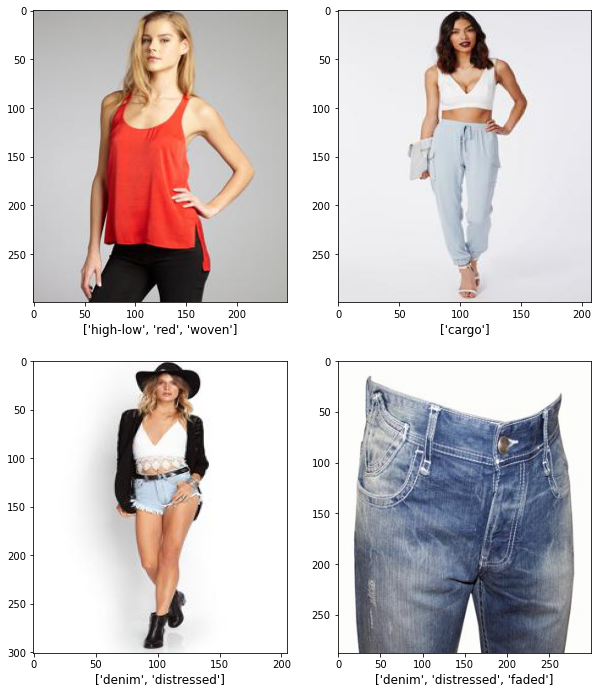

In [103]:
show_images_and_descriptions(filtered_attribute_df_2[filtered_attribute_df_2['image_name'].isin(subsample)], ['att_text'])